# HUFFLEPUFF BUSINESS TRAVEL ANALYSIS

## SOURCES


# BUSINESS PROBLEM #1
- We want our employees to only travel to green countries

## HYPOTHESIS 
- Some countries have lower air travel CO2 emissions per passenger
- In some countries the share of CO2 emmissions created from domestic flights surpasses the ones created from international flights
- Some countries have lower total CO2 emissions total

- Benjamin    : Air travel
- Ricardo     : Energy 
- Anna        : Air pollution 
- Xinly       : Plasctic pollution 
- Jp          : Deforastation 

In [17]:
#TODO remane owid codes to iso codes
#TODO export to sql from python

In [18]:
#imports
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
#!pip install pycountry
import pycountry

### POPULATION CLEANING

In [19]:
#import population data
populations_df = pd.read_csv('sources/population.csv')

def import_csv(filename):
    return pd.read_csv('sources/' + filename)

In [20]:
schema = {
    "population": {
        "filename": "population.csv",
        "columns": {
            "country": {"originalName": "Entity", "type": "object"},
            "population": {"originalName": "Population - Sex: all - Age: all - Variant: estimates", "type": "int"},
            "code": {"originalName": "Code", "type": "object"},
            "year": {"originalName": "Year", "type": "int"},
            },
    },
    
    "deforestation": {
        "filename": "imported-deforestation.csv",
        "columns": {
            "country": {"originalName": "Entity", "type": "object"},
            "imported_deforestation": {"originalName": "imported_deforestation", "type": "float"},
            "code": {"originalName": "ISO_A3", "type": "object"},
            "year": {"originalName": "Year", "type": "int"},
            },
    },
}

In [21]:
#functions
def rename_columns(df, new_names_dict):
    df = df.rename(columns=new_names)
    return df

def clean_owid_data(schema)-> pd.DataFrame:
    df = import_csv(filename)
    df = rename_columns(df)

In [22]:
# rename columns
col_names = {'Entity': 'country', 'Code': 'code', 'Year': 'year','Population - Sex: all - Age: all - Variant: estimates': 'population'}
populations_df = populations_df.rename(columns=col_names)
populations_df.head()



,country,code,year,population
0,Afghanistan,AFG,1950,7776182
1,Afghanistan,AFG,1951,7879343
2,Afghanistan,AFG,1952,7987783
3,Afghanistan,AFG,1953,8096703
4,Afghanistan,AFG,1954,8207953


In [23]:
#population by country latest year
populations_df_latest = populations_df.loc[populations_df.groupby('country')['year'].idxmax()]
populations_df_latest.head()

def get_latest_year_data(df, group_column, year_column = 'year'):
    df_latest = df.loc[df.groupby('country')['year'].idxmax()]
    return df_latest

In [24]:
#drop nan values
populations_df_latest = populations_df_latest.dropna()
populations_df_latest.head()

def drop_nan_values(df):
    df = df.dropna()
    return df

In [25]:
#export clean population csv
populations_df_latest.to_csv('sources/clean/population-clean.csv', index=False)

def export_csv(df, file_name):
    df.to_csv(file_name, index=False)

### DEFORESTATION CLEANING

In [26]:
#import deforestation data
forest_df = pd.read_csv('sources/imported-deforestation.csv')
forest_df = forest_df.rename(columns=col_names)
forest_df.head()

,country,code,year,imported_deforestation
0,Afghanistan,AFG,2005,358.921496
1,Afghanistan,AFG,2006,104.466376
2,Afghanistan,AFG,2007,157.641326
3,Afghanistan,AFG,2008,270.486447
4,Afghanistan,AFG,2009,583.772954


In [27]:
#imported deforestation by country latest year
forest_df_latest = forest_df.loc[forest_df.groupby('country')['year'].idxmax()]
forest_df_latest.head()

,country,code,year,imported_deforestation
8,Afghanistan,AFG,2013,652.573467
17,Albania,ALB,2013,273.964027
26,Algeria,DZA,2013,17952.924036
35,Angola,AGO,2013,5823.889207
44,Argentina,ARG,2013,2288.380098


In [28]:
#export clean deforestation csv
forest_df_latest.to_csv('sources/clean/imported-deforestation-clean.csv', index=False)

### MAPPING

In [29]:
# Load world shape data from geopandas
world = gpd.read_file('maps/110m_cultural/ne_110m_admin_0_countries.shp')

In [30]:
# Merge with the world GeoDataFrame
merged = world.merge(forest_df_latest, how='left', left_on='ISO_A3', right_on='code')

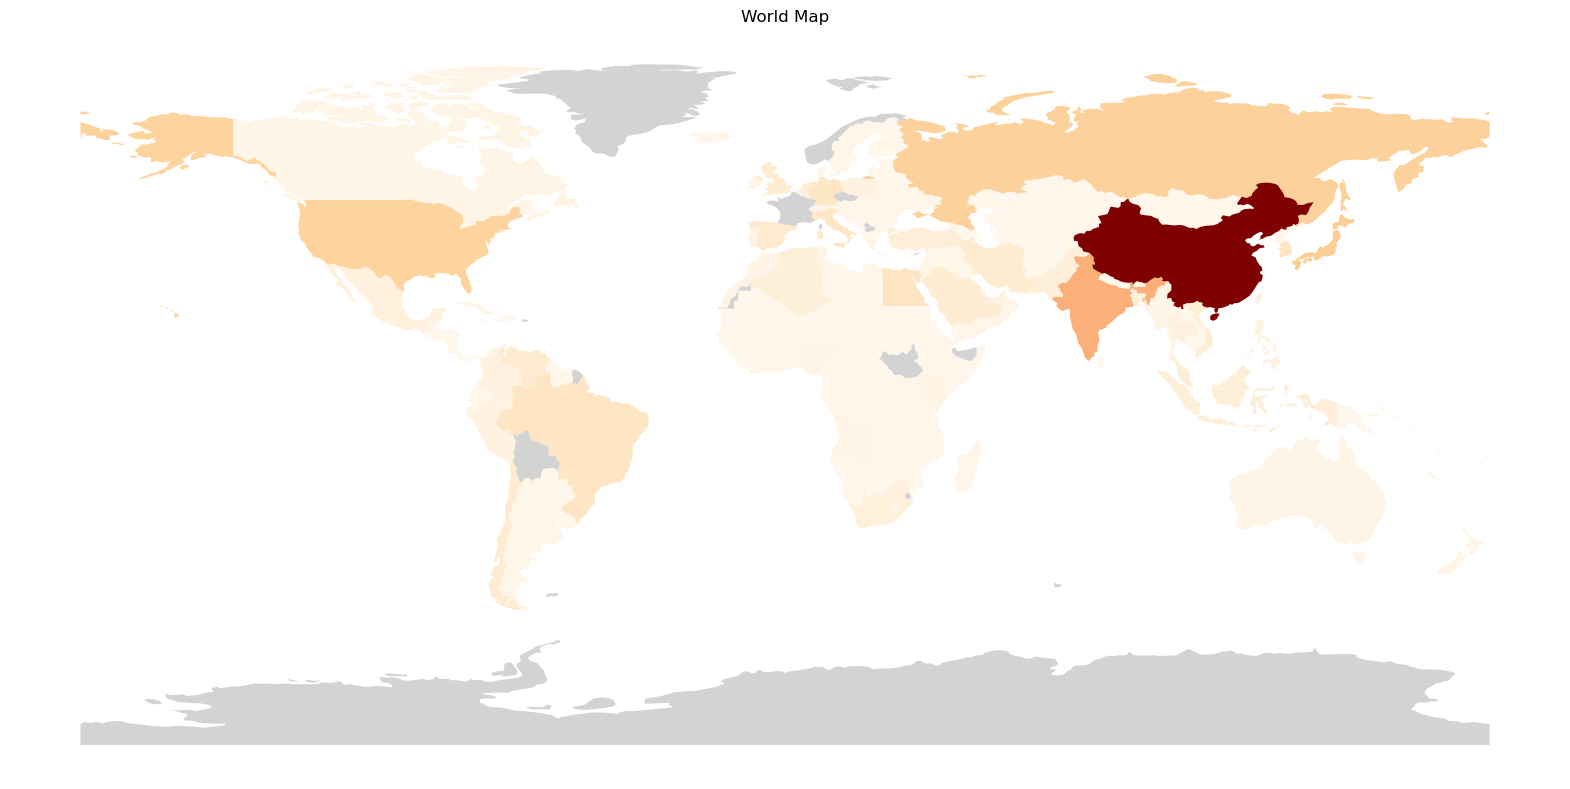

In [31]:
# Plot the map with filled shapes
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the countries with data
merged.plot(column='imported_deforestation', cmap='OrRd', legend=False, ax=ax, missing_kwds={'color': 'lightgrey'})

ax.axis('off')

plt.title('World Map')
plt.show()

### AIR POLLUTION CLEANING

In [32]:
# Load the dataset
file_path = 'https://raw.githubusercontent.com/jipijipi/sql-database/main/sources/AQI%20and%20Lat%20Long%20of%20Countries.csv'
df = pd.read_csv(file_path)

In [33]:
# Convert AQI Value to numeric, coerce errors to handle any non-numeric values
df['AQI Value'] = pd.to_numeric(df['AQI Value'], errors='coerce')

# Group by country and calculate the mean AQI value per country
country_aqi = df.groupby('Country')['AQI Value'].mean().reset_index()

# Min-Max normalization to scale AQI values between 1 and 10
min_aqi = country_aqi['AQI Value'].min()
max_aqi = country_aqi['AQI Value'].max()

country_aqi['Pollution Score'] = 1 + 9 * (country_aqi['AQI Value'] - min_aqi) / (max_aqi - min_aqi)

# Round and convert the Pollution Score to integers
country_aqi['Rounded Pollution Score'] = country_aqi['Pollution Score'].round().astype(int)

In [34]:
# Function to get the 3-letter country code
def get_country_code(country_name):
    try:
        return pycountry.countries.lookup(country_name).alpha_3
    except LookupError:
        return None

# Add a new column with the 3-letter country code
country_aqi['Country Code'] = country_aqi['Country'].apply(get_country_code)